## How machine learning helps you forecast a possible heart disease
In this project, I will compare 2 machine learning models, namely <span style='color:red;background-color:#ffff5e'> XGBoost </span> and <span style='color:red;background-color:#ffff5e'>Random Forest </span>, and also explain the tree structure used for each algorithm. The dataset used for this project is called [`heart-disease-uci`](https://www.kaggle.com/ronitf/heart-disease-uci/data)

**STEP 1: Import required libraries and dataset**  
We need to import 
- pandas: to import data in `Dataframe`
- scikit-learn:  to utilise `Random Forest`
- xgboost: to utilise `Extreme Gradient Boosting` 
- seaborn, matplotlib: to visualise `correlation matrix`and `graphs`

In [1]:
import pandas as pd
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

#Code to center the output
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [2]:
df = pd.read_csv(r'C:\Users\Admin PC\Desktop\BDS\Data Structures & Algorithm\heart.csv')
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

<center><span style='font-style:italic'> Data exploration </span></center>

**STEP 2: Data exploration & Visualisation**  
Let's see what information we can obtain from the given dataset before jumping into modelling in order that our predictive model will perform at its best.

In [3]:
df.loc[:, df.columns != 'target'].describe()

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal  
count  303.000000  
mean     2.313531  
std      0.612277  
min      0.000000  
25%      2.000000  
50%      2.000000  
75%      3.000000  
max      3.000000

<center><span style='font-style:italic'> Statistics about the dataset </span></center>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


<center><span style='font-style:italic'> Check for null-values: This dataset appears to have no missing value </span></center>

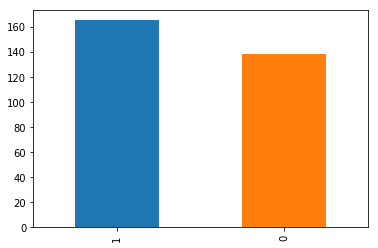

In [5]:
df['target'].value_counts().plot.bar()

<center><span style='font-style:italic'> Check data balance: It’s really essential that the dataset should be approximately balanced. An extremely imbalanced dataset can render the whole model training useless and thus, will be of no use.
    From the bar plot, we can see that our dataset is approximately balanced, which is good enough for our model to proceed</span></center>

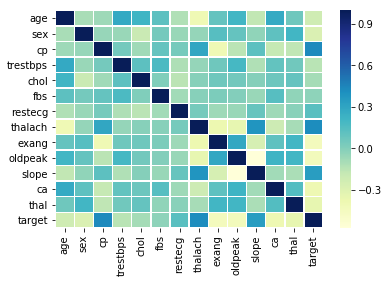

In [6]:
cm = sns.heatmap(df.corr(), linewidths = .5, cmap="YlGnBu")

<center><span style='font-style:italic'> Correlation matrix </span></center>

This correlation matrix gives information about the correlation between each variable of the dataset. The darker the color is, the more correlated the variables are.
For example, we are aiming at predicting the target, and there 3 variables that are highly correlated which called `cp`, `thalach` and `slope`.

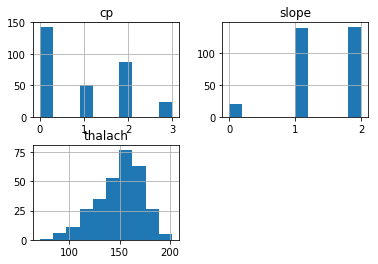

In [7]:
hist = df[['cp', 'thalach', 'slope']].hist()

**STEP 3: Data preparation**  
We will split our dataset into `train` and `test` sets, each set will consists of input `features` and corresponding `labels`

In [8]:
features = df.loc[:, df.columns != 'target'].values[:,:13]
print(features)

[[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. ...  0.  0.  2.]
 [41.  0.  1. ...  2.  0.  2.]
 ...
 [68.  1.  0. ...  1.  2.  3.]
 [57.  1.  0. ...  1.  1.  3.]
 [57.  0.  1. ...  1.  1.  2.]]


<center><span style='font-style:italic'> Input features or Attributes </span></center>

In [9]:
label = df.loc[:, 'target'].values
print(label)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


<center><span style='font-style:italic'> Ground-truth or Labels or Target variables </span></center>

Initialize a MinMaxScaler and scale the features to between -1 and 1 to `normalize them`. The `MinMaxScaler` transforms features by scaling them to a given range. The `fit_transform()` method fits to the data and then transforms it. We don’t need to scale the labels.

In [10]:
scaler = MinMaxScaler((-1,1))
x = scaler.fit_transform(features)
y = label
print(x)

[[ 0.41666667  1.          1.         ... -1.         -1.
  -0.33333333]
 [-0.66666667  1.          0.33333333 ... -1.         -1.
   0.33333333]
 [-0.5        -1.         -0.33333333 ...  1.         -1.
   0.33333333]
 ...
 [ 0.625       1.         -1.         ...  0.          0.
   1.        ]
 [ 0.16666667  1.         -1.         ...  0.         -0.5
   1.        ]
 [ 0.16666667 -1.         -0.33333333 ...  0.         -0.5
   0.33333333]]


Now, `split` the dataset into `training` and `testing` sets keeping 20% of the data for testing.

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=5)

**STEP 4: Train the model**

In this step, I will use two algorithms to train our model, namely:
1. XGB Classifier
2. Random forest classifier

***1. XGB Classifier***

Initialize an `XGBClassifier` and train the model. This classifies using `eXtreme Gradient Boosting`- using gradient boosting algorithms for modern data science problems. It falls under the category of `Ensemble Learning` in ML, where we `train` and `predict` using many models to produce one superior output.

`XGBoost` is a popular and efficient open-source implementation of the `gradient boosted trees` algorithm. Gradient boosting is a `supervised learning` algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models.

In [12]:
model=XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Since `xgboost` is a decision tree based ensemble ML algorithm, the model consists of a set of classification and regression trees (CART). Let's visualise a single decision tree within this trained model to get insight into the `gradient boosting` process.

In [13]:
os.environ['PATH'] += os.pathsep + r'C:\Users\Admin PC\Desktop\BDS\Data Structures & Algorithm\graphviz-2.38\release\bin'

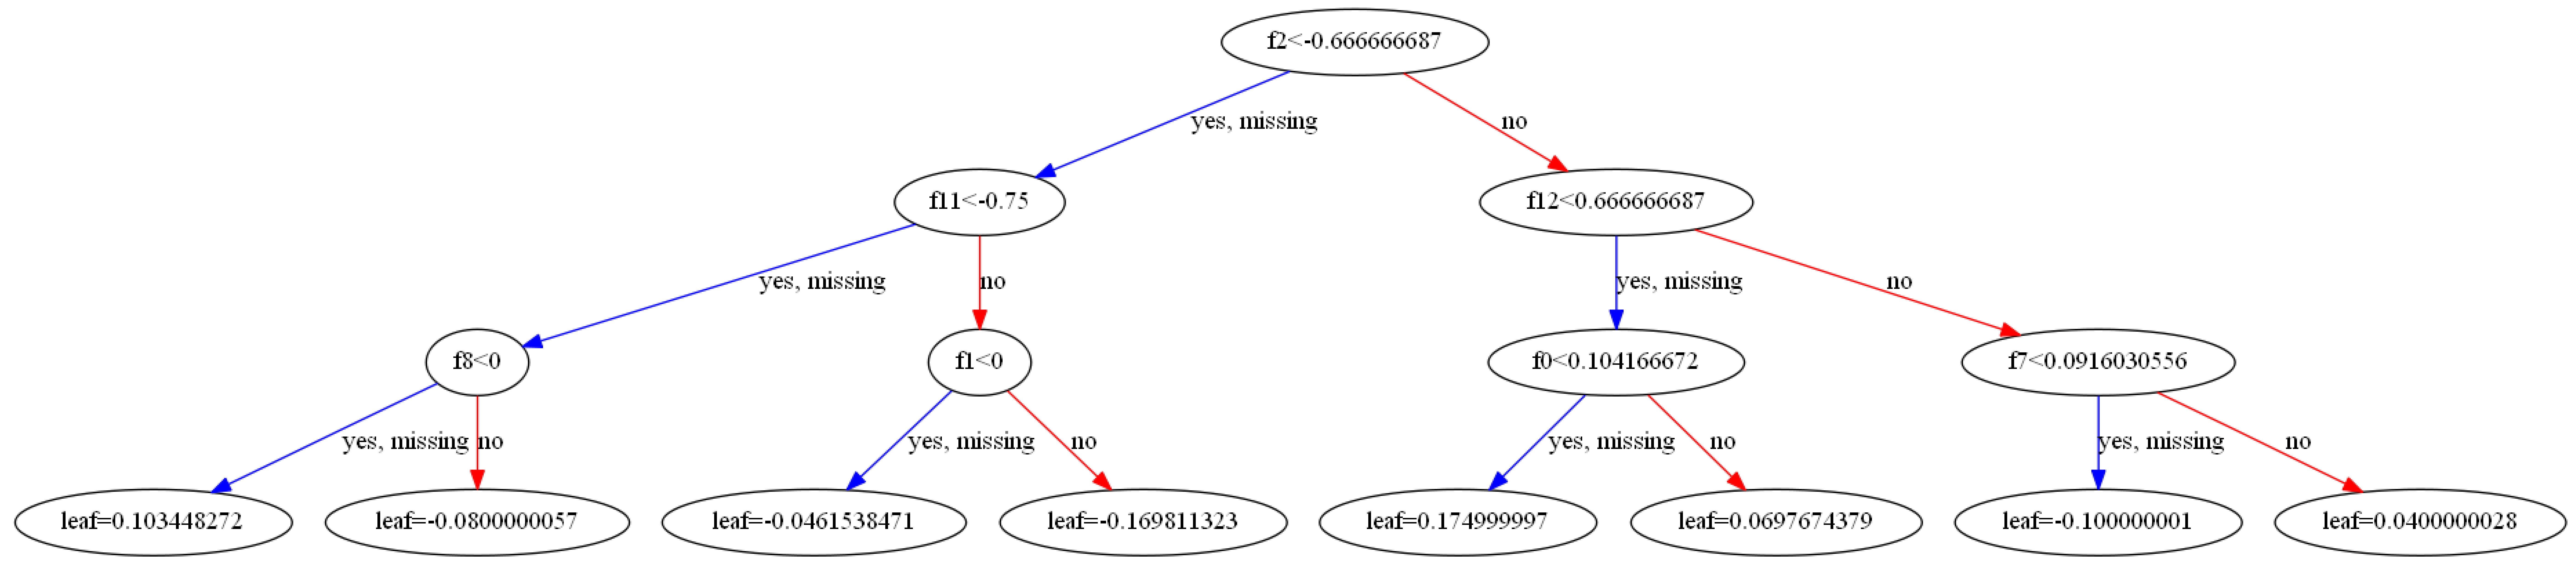

In [14]:
fig, ax = plt.subplots(figsize=(200, 200))
plot_tree(model, num_trees=0, ax=ax)
plt.show()

<center>This is the visualisation of the first decision tree (tree at index 0) in the model.</center>

We can see the features and feature values for each split and also the score of the leaf nodes. The variables are automatically named like f0, f1 corresponding with the feature indices in the input (*for example: f0 reflects age and f1 reflects sex*) 
You can also visualise another decision tree by modifying the parameter `num_trees` with the tree index that you want to visualise. For example, I will visualise the fifth decision tree witht the parameter `num_trees = 4`.

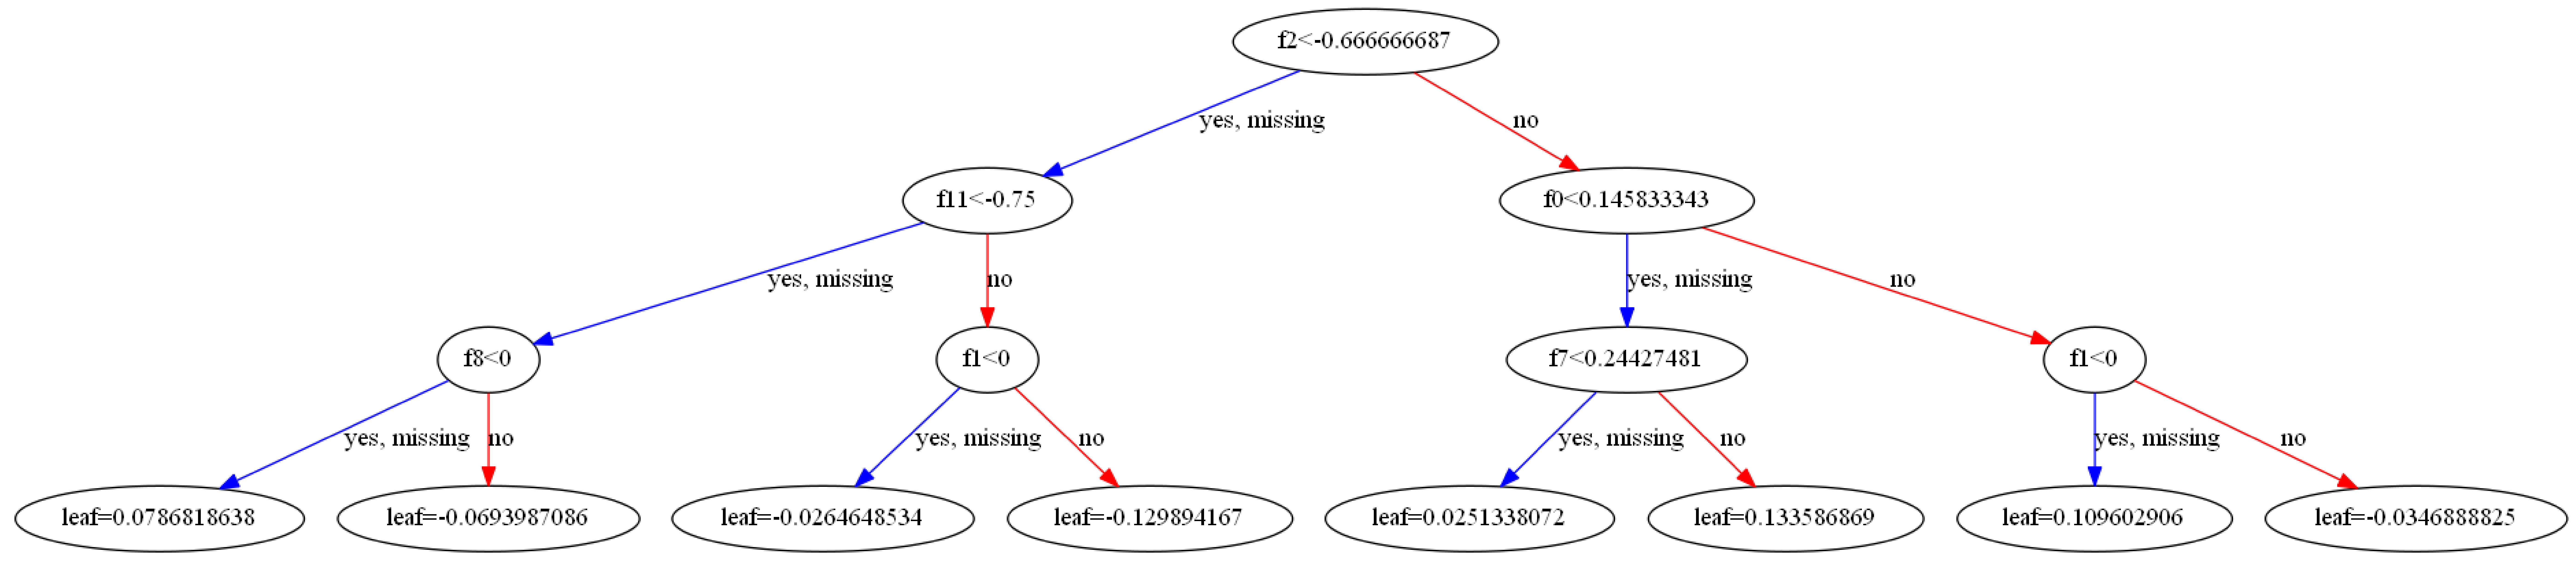

In [15]:
fig, ax = plt.subplots(figsize=(200, 200))
plot_tree(model, num_trees=4, ax=ax)
plt.show()

<center><span style='font-style:italic'> Decision tree at index 4 (the 5th decision tree in the model) </span></center>

Finally, generate `y_pred` (predicted values for `x_test`) and calculate the accuracy for the model. Print it out.

In [16]:
y_pred=model.predict(x_test)
print(accuracy_score(y_test, y_pred)*100)

85.24590163934425


<center><span style='font-style:italic'> XGB algorithm gives us an accuracy of approx. 85% </span></center>

***2. Random Forest Classifier***

Next, we will use `Random Forest Classifier` algorithm. It creates a forest of decision trees where each tree is formed by a random selection of features from the total features. The final decision is made based on the majority of the trees and is chosen by the random forest. 

Let's visualise a single decision tree in the model to see how it works!

In [19]:
model = RandomForestClassifier(n_estimators=10)
model.fit(x_train, y_train)
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz

ft = [i for i in df.columns if i != 'target']
class_name = [str(i) for i in df.target.unique()]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ft,
                class_names = class_name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
from IPython.display import Image
Image(filename = 'tree.png')

<center><span style='font-style:italic'> This is the visualisation of a single decision tree with the information that make the model more understandable </span></center>

Let's understand the parameters of each node in the tree:
1. `Feature name`: feature of each node is decided after selecting a feature from a subset of all features (subsets are formed randomly). Features are chosen based on gini.
2. `Split value`: split value is decided after selecting a threshold value which gives highest information gain for that split.  
(information gain = entropy(parent) — Sum of entropy(child))
3. `Gini`: deciding factor to select feature at next node or to pick best split value.
4. `Samples`: number of samples remaining at that particular node.
5. `Values`: number of samples of each class remaining at that particular node.

With information from the visualisation, we can also make prediction for any new coming data point.
*For example: Let's make prediction for the third patient, who is a woman at the age of 41.* Let's have a look at the data of this patient.

In [20]:
df.iloc[2, :]

age          41.0
sex           0.0
cp            1.0
trestbps    130.0
chol        204.0
fbs           0.0
restecg       0.0
thalach     172.0
exang         0.0
oldpeak       1.4
slope         2.0
ca            0.0
thal          2.0
target        1.0
Name: 2, dtype: float64

Remember that we already normalized the data using `MinMaxScaler`, therefore, data should be in normalised form to make prediction. Let's have a look!

In [21]:
print(x[2])

[-0.5        -1.         -0.33333333 -0.32075472 -0.64383562 -1.
 -1.          0.54198473 -1.         -0.5483871   1.         -1.
  0.33333333]


The normalised data is as followed: `age` = -0.5, `sex` = -1, `cp` = -0.3333, `trestbps` = -0.3207, `chol` = -0.6438, `fbs` = -1, `restecg` = -1, `thalach` = 0.5419, `exang` = -1, `oldpeak` = -0.5483, `slope` = 1, `ca` = -1 and `thal` = 0.3333

- Let's have a look at the visualisation, we start at the root node, which gives us the answer `True` as `thal <= 0.67` --> We move to the `left node`
- For the second question, we have `cp <= -0.67`, which is False --> Move to the `right node`
- Next, `thal <= 0.0` --> False --> Move to `right node`
- `thalach <= 0.44` -- False --> Move to `right node`
- Therefore, we can predict that this patient belong to `class 0` according to the leaf node, which means she has no likelihood to suffer from a heart disease.

This is a wrong prediction as the target class is `1`. However, let's have a look at the root node, this decision tree just used `157` samples despite of `303` training data points. This is understandable because each tree is trained on a random subset of the data (`bagging method`).

***Random sampling of data points, combined with random sampling of a subset of the features at each node of the tree, is why the model is called a ‘random’ forest.***

After having a sense of how this algorithm work, we would want to know how accurate is the prediction this algorithm can produce. Here, we can vary the number of trees that will be used to predict the class. I calculate test scores over 10, 100, 200, 500 and 1000 trees.

In [22]:
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(x_train, y_train)
    rf_scores.append(rf_classifier.score(x_test, y_test))

Let's draw a bar plot to see how accuracy each estimator can bring

[0.8360655737704918, 0.8688524590163934, 0.8852459016393442, 0.9016393442622951, 0.9016393442622951]


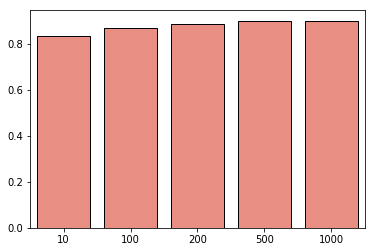

In [23]:
print(rf_scores)
rf = sns.barplot(x = estimators, y = rf_scores, color = 'salmon', edgecolor = (0,0,0), linewidth = 1)

Looking at the bar graph, we can see that the maximum score of `90%` was achieved for both 500 and 1000 trees.

# Summary

In this project, we've learned to analyse the heart disease dataset using various factors. We also trained and tested 2 models and the maximum accuracy is as followed:
1. XGB Classifier: `85%`
2. Random Forest Classifier: `90%`

The `Random Forest Classifier` gives us the best score with an accuracy of `90%`

## Thanks for reading!